# Capítulo 10 - Aprendizado não supervisionado

## Lab 1: PCA

Esse exercício usa o dataset [USArrests](https://www.kaggle.com/deepakg/usarrests).

In [28]:
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram

# Parâmetros estéticos dos gráficos:
set_palette = "Paired"
axes_style = "ticks"

linha = 50*"-"

In [29]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [2]:
df = pd.read_csv("../data/USArrests.csv", index_col=0)
column_names = df.columns

print(f"Tamanho do dataset: {df.shape}")

round(df.describe(), 2)

Tamanho do dataset: (50, 4)


,Murder,Assault,UrbanPop,Rape
count,50.00,50.00,50.00,50.00
mean,7.79,170.76,65.54,21.23
std,4.36,83.34,14.47,9.37
min,0.80,45.00,32.00,7.30
25%,4.08,109.00,54.50,15.08
50%,7.25,159.00,66.00,20.10
75%,11.25,249.00,77.75,26.17
max,17.40,337.00,91.00,46.00


### Padronização

Conforme vimos nas anotações, é importante padronizarmos os valores antes de executar o PCA. Segue abaixo, uma comparação dos resultados obtidos sem padronização dos valores e com padronização:

In [3]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

pca_without_scaling = PCA(n_components=4, random_state=42, whiten=False)
pca_without_scaling.fit(df)

pca = PCA(n_components=4, random_state=42, whiten=False)
pca.fit(df_scaled)

print(f"""Proporção da variância explicada:
- Sem padronização: {pca_without_scaling.explained_variance_ratio_}
- Com padronização: {pca.explained_variance_ratio_}
""")

print(f"""Componentes:
- Sem padronização:
{pd.DataFrame(pca_without_scaling.components_, index=["PCA1", "PCA2", "PCA3", "PCA4"], columns=column_names)}

- Com padronização:
{pd.DataFrame(pca.components_, index=["PCA1", "PCA2", "PCA3", "PCA4"], columns=column_names)}
""")

Proporção da variância explicada:
- Sem padronização: [9.65534221e-01 2.78173366e-02 5.79953492e-03 8.48907879e-04]
- Com padronização: [0.62006039 0.24744129 0.0891408  0.04335752]

Componentes:
- Sem padronização:
        Murder   Assault  UrbanPop      Rape
PCA1  0.041704  0.995221  0.046336  0.075156
PCA2  0.044822  0.058760 -0.976857 -0.200718
PCA3  0.079891 -0.067570 -0.200546  0.974081
PCA4  0.994922 -0.038938  0.058169 -0.072325

- Com padronização:
        Murder   Assault  UrbanPop      Rape
PCA1  0.535899  0.583184  0.278191  0.543432
PCA2  0.418181  0.187986 -0.872806 -0.167319
PCA3 -0.341233 -0.268148 -0.378016  0.817778
PCA4  0.649228 -0.743407  0.133878  0.089024



### Plotando o PVE

Lembrando que PVE é a proprorção de variância explicada.

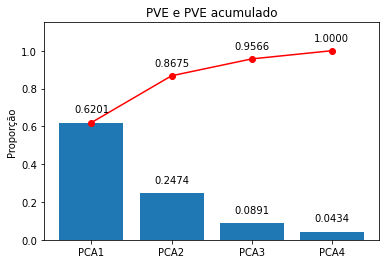

In [4]:
pve = pd.DataFrame(pca.explained_variance_ratio_, columns=["PVE"], index=["PCA1", "PCA2", "PCA3", "PCA4"])

plt.plot(pve.cumsum(), color="r", marker="o")
plt.bar(height=pve.values[:,0], x=[0,1,2,3]);

for x,y in zip([0,1,2,3],pve.values[:,0]):
    label = "{:.4f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip([1,2,3],pve.cumsum().values[1:,0]):
    label = "{:.4f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.title("PVE e PVE acumulado")
plt.ylabel("Proporção")
plt.ylim([0, 1.15]);

## Lab 3: NCI60 Data example

Esse exercício usa o dataset [NCI60](https://www.kaggle.com/ukveteran/nci-60-data).

In [5]:
df_nci60 = pd.read_csv("../data/NCI60.csv", index_col=0)
column_names = df_nci60.columns

print(f"Tamanho do dataset: {df_nci60.shape}")

df_nci60.head(3)

Tamanho do dataset: (64, 6831)


,data.1,data.2,data.3,data.4,data.5,data.6,data.7,data.8,data.9,data.10,...,data.6822,data.6823,data.6824,data.6825,data.6826,data.6827,data.6828,data.6829,data.6830,labs
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-0.070000,0.350000,-0.315000,-0.450000,-0.654981,...,0.000000,0.030000,-0.175000,0.629981,-0.030000,0.000000,0.280000,-0.340000,-1.930000,CNS
V2,0.679961,1.289961,0.169961,0.379961,0.464961,0.579961,0.699961,0.724961,-0.040039,-0.285020,...,-0.300039,-0.250039,-0.535039,0.109941,-0.860039,-1.250049,-0.770039,-0.390039,-2.000039,CNS
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000,0.090000,0.645000,0.430000,0.475019,...,0.120000,-0.740000,-0.595000,-0.270020,-0.150000,0.000000,-0.120000,-0.410000,0.000000,CNS


In [6]:
print(f"""Quantidade de tipos de células: {df_nci60["labs"].value_counts().sum()}""")

df_nci60["labs"].value_counts()

Quantidade de tipos de células: 64


RENAL          9
NSCLC          9
MELANOMA       8
BREAST         7
COLON          7
OVARIAN        6
LEUKEMIA       6
CNS            5
PROSTATE       2
MCF7A-repro    1
K562B-repro    1
K562A-repro    1
MCF7D-repro    1
UNKNOWN        1
Name: labs, dtype: int64

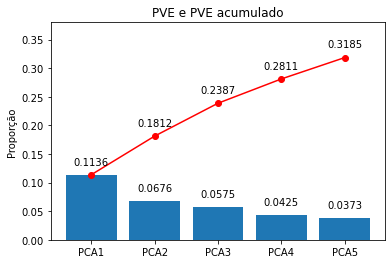

In [7]:
df_scaled = df_nci60.drop(["labs"], axis=1).copy()
column_names = df_scaled.columns
index_names = df_scaled.index

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_scaled)

df_scaled.shape

pca = PCA(n_components=5, random_state=42, whiten=False)
df_scaled_pca = pca.fit_transform(df_scaled)

df_scaled_pca = pd.DataFrame(df_scaled_pca, index=index_names, columns=["PCA1", "PCA2", "PCA3", "PCA4", "PCA5"])

df_scaled_pca["labs"] = df_nci60["labs"]

pve = pd.DataFrame(pca.explained_variance_ratio_, columns=["PVE"], index=["PCA1", "PCA2", "PCA3", "PCA4", "PCA5"])

plt.plot(pve.cumsum(), color="r", marker="o")
plt.bar(height=pve.values[:,0], x=[0,1,2,3,4]);

for x,y in zip([0,1,2,3,4],pve.values[:,0]):
    label = "{:.4f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip([1,2,3,4],pve.cumsum().values[1:,0]):
    label = "{:.4f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.title("PVE e PVE acumulado")
plt.ylabel("Proporção")
plt.ylim([0, .38]);

In [8]:
df_scaled_pca.describe()

,PCA1,PCA2,PCA3,PCA4,PCA5
count,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01
mean,-2.498002e-15,3.219647e-15,-5.828671e-16,2.824130e-15,-1.942890e-16
std,2.807366e+01,2.165117e+01,1.997715e+01,1.716715e+01,1.609803e+01
min,-5.541853e+01,-2.579109e+01,-4.011258e+01,-2.923196e+01,-3.781761e+01
25%,-1.988923e+01,-1.452448e+01,-1.364629e+01,-1.099401e+01,-9.127742e+00
50%,-5.126813e+00,-6.283319e+00,2.274229e+00,-3.368539e+00,-8.346957e-01
75%,1.864321e+01,5.602042e+00,9.807011e+00,7.038074e+00,6.940786e+00
max,6.977793e+01,6.105626e+01,4.688996e+01,5.455196e+01,4.743575e+01


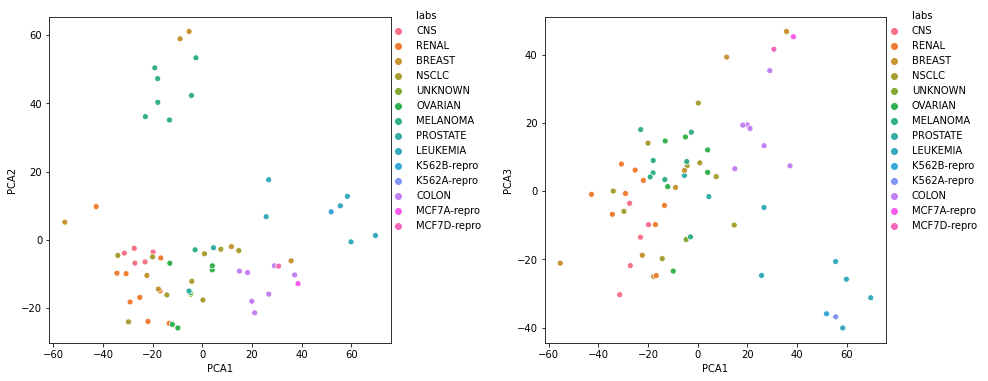

In [9]:
sns.set_palette(set_palette)
sns.axes_style(axes_style)

fig, axs = plt.subplots(ncols=2, figsize=(15,6))

for i, feature in enumerate(df_scaled_pca.columns[1:3]):
    plt.subplots_adjust(wspace = .45)
    ax = sns.scatterplot(x="PCA1", y=feature, hue="labs", data=df_scaled_pca, ax=axs[i])
    ax.legend(frameon=False, loc='right', ncol=1, bbox_to_anchor=(1.28, 0.68), borderaxespad=0.1)


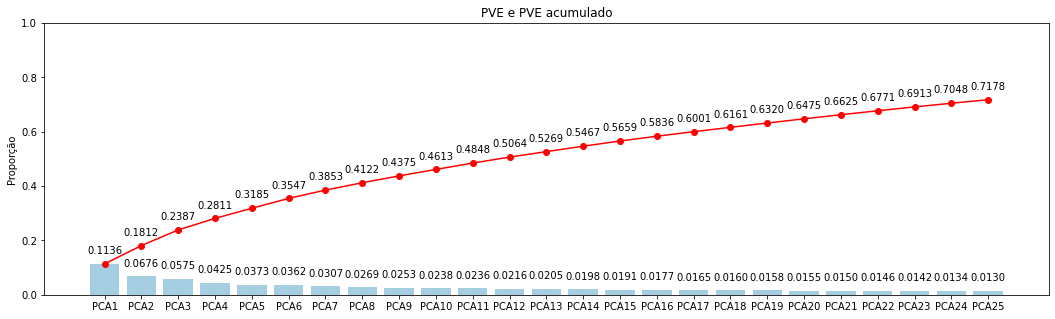

In [63]:
n_components = 25

list_components = ["PCA"+str(x) for x in range(1, n_components+1)]

pca = PCA(n_components=n_components, random_state=42, whiten=False)
df_scaled_pca = pca.fit_transform(df_scaled)

df_scaled_pca = pd.DataFrame(df_scaled_pca, index=index_names, columns=list_components)

df_scaled_pca["labs"] = df_nci60["labs"]

pve = pd.DataFrame(pca.explained_variance_ratio_, columns=["PVE"], index=list_components)

plt.figure(figsize=(18,5))
plt.plot(pve.cumsum(), color="r", marker="o")
plt.bar(height=pve.values[:,0], x=[x for x in range(n_components)]);

for x,y in zip([x for x in range(n_components)],pve.values[:,0]):
    label = "{:.4f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip([x for x in range(1, n_components)], pve.cumsum().values[1:,0]):
    label = "{:.4f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.title("PVE e PVE acumulado")
plt.ylabel("Proporção")
plt.ylim([0, 1]);

### Agrupando observações do NCI60

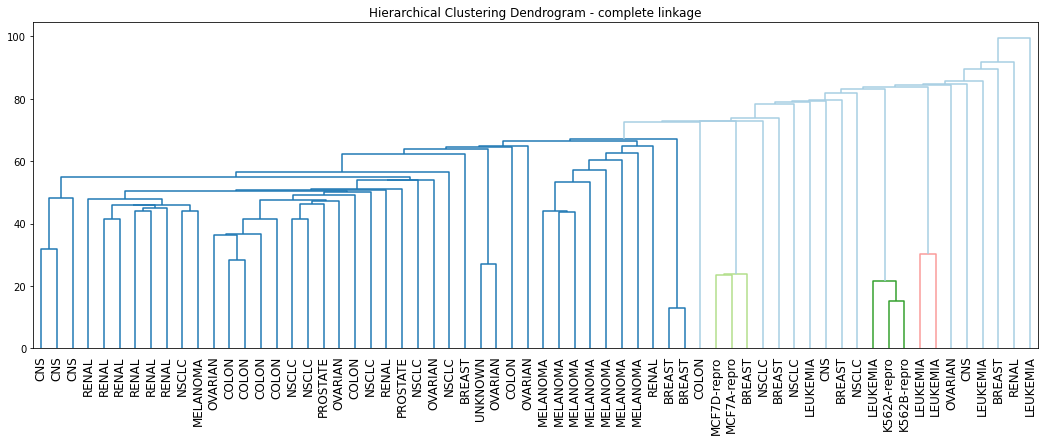

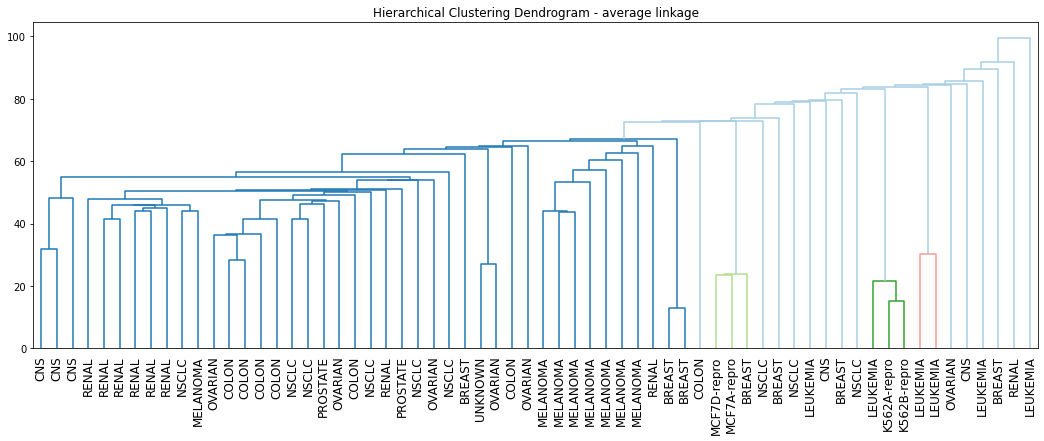

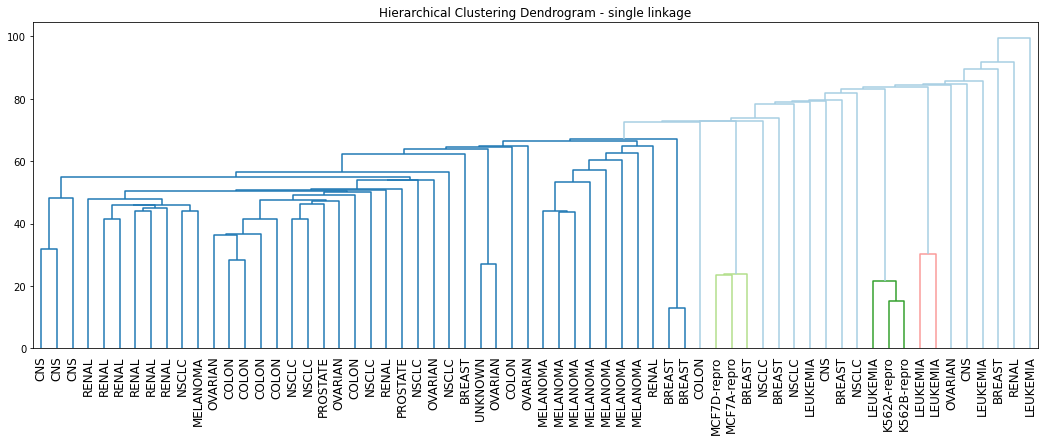

In [70]:
list_linkage = ["complete", "average", "single"]

for linkage_type in list_linkage:

    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="single")

    model = model.fit(df_scaled_pca.drop(["labs"], axis=1), df_scaled_pca["labs"].values)

    # plot the top three levels of the dendrogram
    plt.figure(figsize=(18, 6))
    plt.title('Hierarchical Clustering Dendrogram - '+linkage_type+' linkage')
    plot_dendrogram(model, truncate_mode='level', p=len(df_scaled_pca["labs"].values),
                    labels=df_scaled_pca["labs"].values.tolist())
    plt.xticks(rotation=90)
    plt.xticks(fontsize=12)
    plt.show()